# GMC Issues Licence

![](https://i.ytimg.com/vi/fZ3EPvp12bU/maxresdefault.jpg)

Before issuing a licence the GMC makes a connection with the medic through a face to face meeting arranged by the medical school they are attending. It is here that personally identifiable information, including a headshot of the medic can be collected.

Before the GMC Licence is issued the GMC verifies the medic has recieved a Primary Medical Qualification from a medical school they trust.




## This Would Need Be Configured and Running on the GMC Servers

![Secure Server](https://static.thenounproject.com/png/65152-200.png)

### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController
import os
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

Initialising a controller with admin api at http://general-medical-council-agent:3021 and an api key of adminApiKey


### Start a Webhook Server

In [3]:
webhook_port = int(os.getenv("WEBHOOK_PORT"))
webhook_host = "0.0.0.0"

await agent_controller.init_webhook_server(webhook_host, webhook_port)

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Set Global Identifiers

These specify which schema and issuers to trust and would likely be defined by some governance framework. Note: The GMC already does this, it knows and regulates which medical schools it trusts to educate medics to the required standards.

![](https://www.studymedicineeurope.com/wp-content/uploads/2020/07/NP-_-General-Medicin-Council-7-2020-NS.jpg)

In [4]:
pmq_schema_id = '3jnXQcj9VLFjcUbtDVZZzV:2:Primary Medical Qualification:0.0.2'


In [5]:
trusted_medical_school_dids = ["3jnXQcj9VLFjcUbtDVZZzV"] 


## Retrieve Issuing Schema and Cred Def Identifiers

If you intend for this agent to issue credentials you should first initialise your agent as an issuer and author the relevant identifiers to the public ledger. The issuer_initialisation recipe notebook can be duplicated and used as a starting point.

Once schema and cred def identifiers are created copy across and store in variables as illustrated in the cell below. Be sure to use unique names for each variable.

In [7]:
gmc_schema_id = 'TDAbSf3Uqebg8N4XvybMbg:2:GMC Licence:0.0.2'
gmc_cred_def_id = 'TDAbSf3Uqebg8N4XvybMbg:3:CL:22:gmc'



%store gmc_schema_id
%store gmc_cred_def_id


Stored 'gmc_schema_id' (str)
Stored 'gmc_cred_def_id' (str)


## Register Agent Event Listeners

You can see some examples within the webhook_listeners recipe. Copy any relevant cells across and fill in additional logic as needed.

In [8]:
listeners = []

In [9]:
## YOUR LISTENERS HERE
# Receive connection messages
def connections_handler(payload):
    state = payload['state']
    connection_id = payload["connection_id"]
    their_role = payload["their_role"]
    routing_state = payload["routing_state"]
    
    print("----------------------------------------------------------")
    print("Connection Webhook Event Received")
    print("Connection ID : ", connection_id)
    print("State : ", state)
    print("Routing State : ", routing_state)
    print("Their Role : ", their_role)
    print("----------------------------------------------------------")
    if state == "active":
        # Your business logic
        print(colored("Connection ID: {0} is now active.".format(connection_id), "green", attrs=["bold"]))

connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

listeners.append(connection_listener)

In [10]:
def issuer_handler(payload):
    
    connection_id = payload['connection_id']
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    print("\n---------------------------------------------------\n")
    print("Handle Issue Credential Webhook")
    print(f"Connection ID : {connection_id}")
    print(f"Credential exchange ID : {exchange_id}")
    print("Agent Protocol Role : ", role)
    print("Protocol State : ", state )
    print("\n---------------------------------------------------\n")
    

    
    if state == "offer_sent":
        proposal = payload["credential_proposal_dict"]
        attributes = proposal['credential_proposal']['attributes']

        print(f"Offering credential with attributes  : {attributes}")
        ## YOUR LOGIC HERE
    elif state == "request_received":
        print("Request for credential received")
        ## YOUR LOGIC HERE
    elif state == "credential_sent":
        print("Credential Sent")
        ## YOUR LOGIC HERE
    
issuer_listener = {
    "topic": "issue_credential",
    "handler": issuer_handler
}

listeners.append(issuer_listener)

In [11]:

def verifier_proof_handler(payload):
    role = payload["role"]
    connection_id = payload["connection_id"]
    pres_ex_id = payload["presentation_exchange_id"]
    state = payload["state"]
    print("\n---------------------------------------------------------------------\n")
    print("Handle present-proof")
    print("Connection ID : ", connection_id)
    print("Presentation Exchange ID : ", pres_ex_id)
    print("Protocol State : ", state)
    print("Agent Role : ", role)
    print("Initiator : ", payload["initiator"])
    print("\n---------------------------------------------------------------------\n")
    

    if state == "request_sent":
        print("Presentation Request\n")
        print(payload["presentation_request"])
        print("\nThe presentation request is encoded in base64 and packaged into a DIDComm Message\n")
        print(payload["presentation_request_dict"])
        print("\nNote the type defines the protocol present-proof and the message request-presentation\n")
        print(payload["presentation_request_dict"]["@type"])
    elif state == "presentation_received":
        print("Presentation Received")
        print("We will not go into detail on this payload as it is comparable to the presentation_sent we looked at in the earlier cell.")
        print("This is the full payload\n")
    else:
        print(state)
        
verifier_listener = {
    "topic": "present_proof",
    "handler": verifier_proof_handler
}

listeners.append(verifier_listener)


In [12]:
def revocation_handler(payload):

    print("Revocation Event Handled")
    print(payload)
    

revocation_listener = {
    "topic": "revocation_registry",
    "handler": revocation_handler
}

listeners.append(revocation_listener)


In [13]:
agent_controller.register_listeners(listeners)

# Meet Medic Face to Face through Medical School Introduction

![](https://cdn.lynda.com/course/693079/693079-637563419540730258-16x9.jpg)

## GMC and Medical Student Establish Connection

A GMC Administrative Staff would be introduced to each Medical student in a physical meeting organised by the medical school. As part of this meeting **which already happens**, the GMC Admin staff could establish a DIDComm connection between the ACA-Py agent representing the GMC (which they would have to be authorised to use) and the medic's agent.

Both parties can therefore have a high degree of confidence that the digital connection they just established represents the entity they think it does. E.g. a medical student, or the GMC.

In [14]:
# Alias for invited connection
alias = "Medic"
auto_accept = "true"
# Use public DID?
public = "false"
# Should this invitation be usable by multiple invitees?
multi_use = "false"

invitation_response = await agent_controller.connections.create_invitation(alias, auto_accept, public, multi_use)
# Is equivalent to above. Arguments are optionally
# invitation_response = await agent_controller.connections.create_invitation()



# You will use this identifier to issue a credential across this connection
connection_id = invitation_response["connection_id"]

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  1ef8fa6a-73bb-4cf2-b3c8-7418042365b9
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------


## Share Invitation Object with Medic

Again this would likely happen as part of a face to face interaction.

In [15]:
invitation = invitation_response["invitation"]
## Copy this output
print(invitation)

{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': '8f8ecd88-0cd4-4a9a-85f7-3987a1f0d24c', 'recipientKeys': ['EzdcJkKmiReSXVcP5BVFoXsJKdUdvKzCpe94FzXMyNCp'], 'serviceEndpoint': 'http://f3a3-82-33-73-116.ngrok.io', 'label': 'General Medical Council'}
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  1ef8fa6a-73bb-4cf2-b3c8-7418042365b9
State :  request
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  1ef8fa6a-73bb-4cf2-b3c8-7418042365b9
State :  response
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  1ef8fa6a-73bb-4cf2-b3c8-7418042365b9
State :  active
Routing State :  non

## Optional: Display Invite as QR Code

Most likely the medic would be using a mobile to connect with the GMC

In [ ]:
import qrcode
# Link for connection invitation
invitation_url = invitation_response["invitation_url"]
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=5,
        border=5)
qr.add_data(invitation_url)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img

## Collect Key Information about Medic

* Name (verified from valid identity document & the medical school)
* Photo
* Medical School 

etc

Note this could be stored in the GMC system against the connection identifier just created by establishing a DIDComm connection with the medic. 

![](https://www.wikihow.com/images/thumb/a/ab/Get-a-Certified-Copy-of-Your-Passport-Step-1.jpg/v4-460px-Get-a-Certified-Copy-of-Your-Passport-Step-1.jpg.webp)

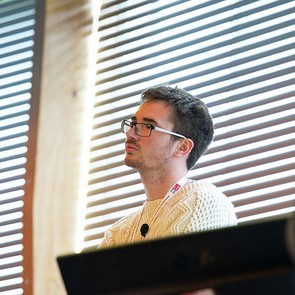

In [16]:
from IPython.display import Image
Image("headshot.jpg")


## Request Proof Medic Has Completed Their Medical Education

Before a healthcare professional can be licenced in the UK they must demonstrate they are in posession of a Primary Medical Qualification

In [17]:
import time

# Define the list of attributes and restrictions under which each attribute was issued that a prover must satisfy with a presentation
# NOTE: if identifying a schema or credential definition then the attribute name must be contained within the corresponding schema.
req_attrs = [
    {"name": "Name", "restrictions": [{"schema_id": pmq_schema_id}]},
    {"name": "University", "restrictions": [{"schema_id": pmq_schema_id}]},
    {"name": "Date Issued", "restrictions": [{"schema_id": pmq_schema_id}]},
]

# We could extend this to request the name attribute aswell if we wanted.


pmq_proof_request = {
    "name": "Proof of Primary Medical Qualification",
    "version": "1.0",
    "requested_attributes": {
        # They must follow this uuid pattern
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },

    "requested_predicates": {
#         f"0_{req_pred['name']}_GE_uuid":
#         req_pred for req_pred in req_preds
    },
    # You can also request the entire proof request be non-revoked
    "non_revoked":  {"to": int(time.time())}
}

## Send Proof Request

This identifies a connection and a proof request object (you will need to update the variable name enclosed with <>) 

In [18]:
proof_request = {
    "comment": "Please prove that you have recieved a valid PMQ",
    "connection_id": connection_id,
    "proof_request": pmq_proof_request,
    # Do you want your agent to trace this request (for debugging)
    "trace": True
}

proof_request_response = await agent_controller.proofs.send_request(proof_request)


---------------------------------------------------------------------

Handle present-proof
Connection ID :  1ef8fa6a-73bb-4cf2-b3c8-7418042365b9
Presentation Exchange ID :  2622e7e5-da5e-4b43-b859-b1a82a28772d
Protocol State :  request_sent
Agent Role :  verifier
Initiator :  self

---------------------------------------------------------------------

Presentation Request

{'nonce': '1190454733646398233440922', 'name': 'Proof of Primary Medical Qualification', 'version': '1.0', 'requested_attributes': {'0_Name_uuid': {'name': 'Name', 'restrictions': [{'schema_id': '3jnXQcj9VLFjcUbtDVZZzV:2:Primary Medical Qualification:0.0.2'}]}, '0_University_uuid': {'name': 'University', 'restrictions': [{'schema_id': '3jnXQcj9VLFjcUbtDVZZzV:2:Primary Medical Qualification:0.0.2'}]}, '0_Date Issued_uuid': {'name': 'Date Issued', 'restrictions': [{'schema_id': '3jnXQcj9VLFjcUbtDVZZzV:2:Primary Medical Qualification:0.0.2'}]}}, 'requested_predicates': {}, 'non_revoked': {'to': 1630332517}}

The prese

## Get PMQ Presentation Exchange Record

This record keeps track of the current state of the presentation protocol, which must be in the `presentation_received` state before the presentation can be verified.

Note: This could also happen in the webhook logic.

In [19]:
presentation_exchange_id = proof_request_response["presentation_exchange_id"]

pres_record = await agent_controller.proofs.get_record_by_id(presentation_exchange_id)

## Verify PMQ Presentation

Only if it is in the right state. 

Note: Verifying a presentation moves the state to `verified` regardless of whether the presentation request has been satisfied. To check this you must refer to the `verified` property on the response.

In [20]:
verified_response = await agent_controller.proofs.verify_presentation(presentation_exchange_id)

verified = verified_response["verified"]
print("Valid PMQ Presented : " + verified)


---------------------------------------------------------------------

Handle present-proof
Connection ID :  1ef8fa6a-73bb-4cf2-b3c8-7418042365b9
Presentation Exchange ID :  2622e7e5-da5e-4b43-b859-b1a82a28772d
Protocol State :  verified
Agent Role :  verifier
Initiator :  self

---------------------------------------------------------------------

verified
Valid PMQ Presented : true


## Fetching Issuing DID for Disclosed PMQ

The GMC will want to check that this credential was issued by a medical school they trust. Likely they would compare this against a list of verified medical schools.

Note: Other identifiers might also be useful for similar purposes.

In [21]:
identifiers_list = verified_response['presentation']["identifiers"]
print(identifiers_list)
trusted = False
for identifiers in identifiers_list:
    cred_def_id = identifiers["cred_def_id"]
    issuing_did = cred_def_id.split(":")[0]
    print(issuing_did)
    if issuing_did in trusted_medical_school_dids:
        trusted = True
        print(colored("Issuer {0} is trusted to issued PMQ Credentials".format(issuing_did), "green", attrs=["bold"]))
        break
    
if not trusted:
    print(colored("Issuer Not Trusted", "red", attrs=["bold"]))

[{'schema_id': '3jnXQcj9VLFjcUbtDVZZzV:2:Primary Medical Qualification:0.0.2', 'cred_def_id': '3jnXQcj9VLFjcUbtDVZZzV:3:CL:14:default'}]
3jnXQcj9VLFjcUbtDVZZzV
Issuer 3jnXQcj9VLFjcUbtDVZZzV is trusted to issued PMQ Credentials


## Parsing Disclosed Attribute Values from Presentation

A presentation object contains three classes of attributes. 
* Revealed Attributes: Attributes that were signed by an issuer and have been revealed in the presentation process
* Self Attested Attributes: Attributes that the prover has self attested to in the presentation object.
* Predicate proofs: Attribute values that have been proven to meet some statement. (TODO: Show how you can parse this information)

### Parse Revealed Attributes

These will be verified against attributes already stored against connection from physical meeting.

In [22]:
for (name, val) in verified_response['presentation']['requested_proof']['revealed_attrs'].items():
    ## This is the actual data that you want. It's a little hidden
    print("\nAttribute : ", val)
    
    attr_name = verified_response["presentation_request"]["requested_attributes"][name]["name"]
    print(f"\nRaw Value - {attr_name} : {val['raw']}")


Attribute :  {'sub_proof_index': 0, 'encoded': '57963125648994666300875361621729313351158154740138173103415020334594043694317', 'raw': 'Edinburgh Medical School'}

Raw Value - University : Edinburgh Medical School

Attribute :  {'sub_proof_index': 0, 'encoded': '49272594129721906234329760951764944925631279077622505421027966796577006025440', 'raw': 'Will'}

Raw Value - Name : Will

Attribute :  {'sub_proof_index': 0, 'encoded': '30619688953657365627019941655883455207298210903833998052457827755245155989270', 'raw': '2021-08-30'}

Raw Value - Date Issued : 2021-08-30


## Issue GMC Licence

The GMC admin staff would issue a GMC credential to medical students only if:

* They can demonstrate they have a valid PMQ from a trusted medical school
* They have demonstrated they are eligible to work in the UK
* They successfully complete a standard DBS check

This credential and the attributes encoded within in it are going to be used as roots of trust throughout healthcare institutions. It is imperative that they are issued accurately to correctly identified medics devices.

Fortunately, the medic is also highly motivated to receive an accurate set of high assurance attributes that they will be able to use throughout their future healthcare interactions.

The GMC Admin staff is going to establish the digital connection and collect these details in person. This includes:

* Checking an identification document for the individual (e.g. Passport)
* Checking the name on the PMQ matches this information
* Taking a photo of the medic to be encoded into the credential

## Encode Image of Medical Professional

A passport style headshot photograph taken by a GMC Admin team when initially introduced to the medic by their Medical School

In [23]:
import base64
encoding = 'utf-8'
with open("headshot.jpg", "rb") as image:
    my_string = base64.b64encode(image.read())
    headshotBase64 = my_string.decode('utf-8')

In [24]:
from datetime import date, timedelta
import json

attributes = ["GMC Number", "Responsible Officer GMC Number", "Licenced From", "Re-Validation Due", "Name", "Base64Image", "DOB"]

gmc_number="1231231" # input("Please enter the doctors GMC Number: ")
resp_officer="3827123"  # input("Please enter the GMC Number for the doctors responsible officer: ")
licenced_from=date.today().isoformat()
revalidation_due = (date.today() + timedelta(days=1825)).isoformat()
name="Will A"  # input("Please enter the doctors name")
headshot_holder=headshotBase64
dob="25/01/20" # input("Enter doctors date of birth")
credential_attributes = [
    {"name": "GMC Number", "value": gmc_number},
    {"name": "Responsible Officer GMC Number", "value": resp_officer},
    {"name": "Licenced From", "value": licenced_from},
    {"name": "Re-Validation Due", "value": revalidation_due},
    {"name": "Name", "value": name},
    {"name": "Base64Image", "value": headshot_holder},
    {"name": "DOB", "value": dob}
]

## Issue GMC Licence Credential

GMC Licence is only issued once the GMC has verified the Primary Medical Qualification.


In [25]:
# Do you want the ACA-Py instance to trace it's processes (for testing/timing analysis)
trace = True
comment = ""
# Remove credential record after issued?
auto_remove = False

# Change <schema_id> and <cred_def_id> to correct pair. Cred_def_id must identify a definition to which your agent has corresponding private issuing key.
if True:
    print("Medic has completed their primary medical qualication")
    send_cred_response = await agent_controller.issuer.send_credential(connection_id, gmc_schema_id, gmc_cred_def_id, credential_attributes, comment, auto_remove, trace)
    gmc_licence_cred_ex_id = send_cred_response["credential_exchange_id"]
# Note last three args are optional.
# await agent_controller.issuer.send_credential(connection_id, <schema_id>, <cred_def_id, credential_attributes)

Medic has completed their primary medical qualication

---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : 1ef8fa6a-73bb-4cf2-b3c8-7418042365b9
Credential exchange ID : cecf7ab8-8ea1-43f3-a045-e9c65a821fde
Agent Protocol Role :  issuer
Protocol State :  offer_sent

---------------------------------------------------

Offering credential with attributes  : [{'name': 'GMC Number', 'value': '1231231'}, {'name': 'Responsible Officer GMC Number', 'value': '3827123'}, {'name': 'Licenced From', 'value': '2021-08-30'}, {'name': 'Re-Validation Due', 'value': '2026-08-29'}, {'name': 'Name', 'value': 'Will A'}, {'name': 'Base64Image', 'value': '/9j/4AAQSkZJRgABAQAAAQABAAD/4QQwRXhpZgAASUkqAAgAAAAOAAABAwABAAAAQBMAAAEBAwABAAAA0AwAAAIBAwADAAAAtgAAAA4BAgCLAAAAvAAAAA8BAgASAAAASAEAABABAgAJAAAAWgEAABIBAwABAAAAAQAAABUBAwABAAAAAwAAABoBBQABAAAAZAEAABsBBQABAAAAbAEAACgBAwABAAAAAgAAADEBAgAQAAAAdAEAAJiCAgAdAAAAhAEAAGmHBAABAAAAogEAAAAAAAAIAAgACAA1dGggSW50ZXJuYXRpb

## Optional: Revoke GMC Licence Credential

Only possible if the credential issued used a revocable credential definition. (see support_revocation flag in write_cred_def() function).

There are two approachs to revoke an revocable credential

### Option 1: Use credential Exchange ID

Note: In a SSI application as an issuer you are might want to keep track of the identifiers for credential echange records. These can be used to retrieve records stored by the agent and also be used to identify a credential to revoke
Note though that applications might not wish to retain these records as they contain sensitive PII

In [ ]:
response = await agent_controller.issuer.get_records()
record = response["results"][0]
print(record)

In [ ]:
# record_id = record["credential_exchange_id"]
try:
    is_record = await agent_controller.issuer.get_record_by_id(gmc_record_id)
except:
    print("Record not found. Did your agent automatically remove it?")

if True:
    # For revoke_credential() you only need to provide (cred_ex_id) OR (rev_reg_id AND cred_rev_id).
    response = await agent_controller.revocations.revoke_credential(gmc_record_id, publish=True)
    response

### Option 2: Remove Credential using the Registry and Credential Revocation ID

Does not currently work because of bug in code

In [ ]:
registry = await agent_controller.revocations.get_active_revocation_registry_by_cred_def(gmc_cred_def_id)
print(registry["result"]["revoc_reg_entry"])

In [ ]:
revoc_reg_id = registry["result"]["revoc_reg_id"]

### Or ...

In [ ]:
gmc_record = await agent_controller.issuer.get_record(gmc_licence_cred_ex_id)
rev_reg_id = gmc_record["credential"]["rev_reg_id"]

In [ ]:
# Public revocation registry update to ledger
publish = True
# Believe this is index in rev registry starting from 1
cred_rev_id = "1"
response = await agent_controller.revocations.revoke_credential(cred_rev_id = cred_rev_id, rev_reg_id = revoc_reg_id, publish=True)

## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [ ]:
await agent_controller.terminate()